In [133]:
import gc
import numpy as np
import pandas as pd
import sys
import re
from glob import glob
import os
HOME = os.path.expanduser('~')
sys.path.append(f"{HOME}/kaggle/github/library/")
#  sys.path.append(f"/mnt/c/Git/go/kaggle/github/library/")
import utils
from utils import logger_func
import eda
import matplotlib.pyplot as plt
import seaborn as sns 

logger = logger_func()

key = 'SK_ID_CURR'
target = 'TARGET'
ignore_list = [key, target]

utils.start(sys.argv[0])

app = utils.read_df_pickle(path='../input/application_train_test*.p')[[key, target, 'AMT_ANNUITY', 'EXT_SOURCE_2', 'DAYS_BIRTH']].dropna()

# ==================================================
utils.end(sys.argv[0])

2018-10-17 13:07:32,868 utils 353 [INFO]    [logger_func] start 
2018-10-17 13:07:32,868 utils 353 [INFO]    [logger_func] start 
2018-10-17 13:07:32,868 utils 353 [INFO]    [logger_func] start 
  0%|          | 0/3 [00:00<?, ?it/s]


#==============================================================================
# START!!! /mnt/c/Users/gixo/go/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py    PID: 30758    time: 2018-10-17 13:07:32.880384
#==============================================================================



100%|██████████| 3/3 [00:00<00:00,  3.74it/s]



#==============================================================================
# SUCCESS !!! /mnt/c/Users/gixo/go/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py
#==============================================================================

time: 0.04min


### Make Dataset

0.08168


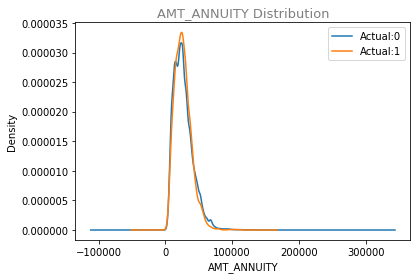

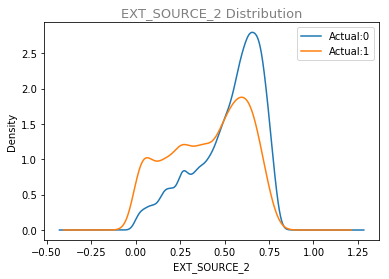

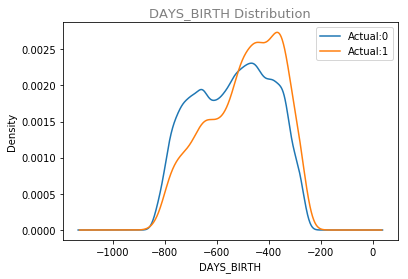

In [174]:
app = app[app[target]>=0]
train = app.sample(250000, random_state=1208)
train_idx = list(train.index)
app_idx = list(app.index)
test_idx = list(set(app_idx) - set(train_idx))
test = app.loc[test_idx, :].sample(50000, random_state=1208)
df = test
print(df[target].mean())
for col in df.columns: 
    if col in ignore_list:
        continue
    eda.feature_vs_y(feature=df[col], y=df[target])

In [176]:
# train.to_csv('../input/1015_exp1_train.csv', index=False)
# test.to_csv('../input/1015_exp1_test.csv', index=False)

指定のfeatureについて指定の範囲の値を指定したN数だけ取り出しデータセットを作成する

In [145]:
def arbitrary_range_sample(df, feature, min_val, max_val, N, seed=1208):
    range_idx = df[ (min_val <= df[feature]) & (df[feature] <= max_val) ].index
    df = df.loc[range_idx, :]
    print(df.shape)
    df = df.sample(N, random_state=seed)
    return df


def make_distribution(df, target_value, lam):
    dist = []
    for i in range(len(df.query(f"TARGET=={target_value}"))):
        np.random.seed(i**2)
        dp = np.random.poisson(lam=lam)/100
        dist.append(dp)
    dist = np.array(dist)
    dist[dist>1] = 1
    df.loc[df[df[target]==target_value].index, feat_name] = dist
    
    return df

TestSetの作成

In [177]:
feat_name = 'EXT_SOURCE_2'
seed=1208

#========================================================================
# 変数の値ごとのサンプル数を統一する場合
#========================================================================
N=1900
df_exp = pd.DataFrame()
for i in range(8):
    tmp = arbitrary_range_sample(df=test, feature=feat_name, min_val=i*0.1, max_val=0.1+(i*0.1), N=N, seed=seed)
    if len(df_exp):
        df_exp = pd.concat([df_exp, tmp], axis=0)
    else:
        df_exp = tmp.copy()
print(df_exp.shape)
print(df_exp.head())

(1910, 5)
(2660, 5)
(3857, 5)
(4412, 5)
(6241, 5)
(9924, 5)
(13344, 5)
(7557, 5)
(15200, 5)
        SK_ID_CURR  TARGET  AMT_ANNUITY  EXT_SOURCE_2  DAYS_BIRTH
163179      289183       0      28588.5      0.077616        -570
123778      243542       0      40527.0      0.023499        -646
304340      452602       0      47272.5      0.002353        -790
297156      444269       0      18679.5      0.043220        -727
114796      233117       0      16155.0      0.046240        -303


=== Train: EXT_SOURCE_2 ===
Train Shape: (250000, 5)


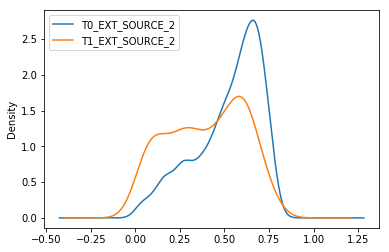

=== EXP VALIDATION: EXT_SOURCE_2 ===
Test Shape: (15200, 5)


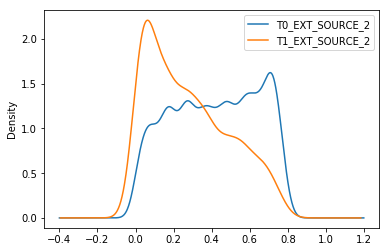

SystemExit: 

In [156]:
feat_name = 'EXT_SOURCE_2'

print(f"=== Train: {feat_name} ===")
print(f"Train Shape: {train.shape}")
# ORIGINAL PLOT
train.iloc[trn_idx, :].query("TARGET==0").rename(columns={feat_name:f"T0_{feat_name}"})[f"T0_{feat_name}"].plot(kind='kde', legend=True, bw_method=None)
train.iloc[trn_idx, :].query("TARGET==1").rename(columns={feat_name:f"T1_{feat_name}"})[f"T1_{feat_name}"].plot(kind='kde', legend=True, bw_method=None)
plt.show()


# EXPERIENCE PLOT
print(f"=== EXP VALIDATION: {feat_name} ===")
print(f"Test Shape: {df_exp.shape}")
df_exp.query("TARGET==0").rename(columns={feat_name:f"T0_{feat_name}"})[f"T0_{feat_name}"].plot(kind='kde', legend=True, bw_method=None)
df_exp.query("TARGET==1").rename(columns={feat_name:f"T1_{feat_name}"})[f"T1_{feat_name}"].plot(kind='kde', legend=True, bw_method=None)
# df_exp.rename(columns={feat_name:f"T1_{feat_name}"})[f"T1_{feat_name}"].plot(kind='kde', legend=True, bw_method=None)
plt.show()

sys.exit()


In [187]:
# Validation
from sklearn.model_selection import StratifiedKFold
' KFold '
fold_type='stratified'
fold=5
seed=1208
kind='kde'

# train = pd.read_csv('../input/1015_exp1_train.csv')
# test = pd.read_csv('../input/1015_exp1_test.csv')
tmp_train = train.reset_index(drop=True).copy()
test = df_exp.copy()
test.set_index(key, inplace=True)

X = tmp_train.drop(target, axis=1)
Y = tmp_train[target]

if fold_type=='stratified':
    folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed) #1
    kfold = folds.split(X, Y)
    
for trn_idx, val_idx in kfold:
    x_train = X.loc[trn_idx, :]
    y_train = Y.loc[trn_idx]
    x_val = X.loc[val_idx, :]
    y_val = Y.loc[val_idx]
    
    x_train.set_index(key, inplace=True)
    y_train.index = x_train.index
    x_val.set_index(key, inplace=True)
    y_val.index = x_val.index
    
#     for col in x_train.columns:
#         print("train")
#         eda.feature_vs_y(feature=x_train[col], y=y_train, kind=kind)
#         print("Validation")
#         eda.feature_vs_y(feature=x_val[col], y=y_val, kind=kind)
#     sys.exit()

In [190]:
import lightgbm as lgb
sys.path.append(f"{HOME}/kaggle/github/model/")
# =====================
# Parameter
# =====================
params = {
    'metric':'auc'
}
early_stopping_rounds=50
learning_rate=0.1
num_boost_round=500
categorical_list=[]

# =====================
# Validation Set!!
# =====================
validation = x_val
# print(tmp.columns)
# print(x_val.columns)

use_cols = ['AMT_ANNUITY', 'EXT_SOURCE_2']
# use_cols = ['EXT_SOURCE_2']

lgb_train = lgb.Dataset(data=x_train[use_cols], label=y_train)
lgb_eval = lgb.Dataset(data=validation[use_cols], label=y_val)

print(f"Train Shape: {x_train.shape}")
print(f"Validation Shape: {validation.shape}")
# =====================
# Train
# =====================
clf = lgb.train(params=params,
                early_stopping_rounds=early_stopping_rounds,
                num_boost_round=num_boost_round,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                verbose_eval=50,
                categorical_feature = categorical_list
                )
y_pred = clf.predict(test[clf.feature_name()])
test['pred'] = y_pred

Train Shape: (200001, 3)
Validation Shape: (49999, 3)
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.667867
[100]	valid_0's auc: 0.668807
[150]	valid_0's auc: 0.668697
Early stopping, best iteration is:
[115]	valid_0's auc: 0.669027


In [186]:
# x_train['EXT_SOURCE_2']

23057     0.773538
289315    0.590937
117618    0.498231
162658    0.245350
77234     0.647468
227967    0.638629
207218    0.180856
281180    0.265312
6075      0.479442
280951    0.587720
208808    0.713229
199690    0.784986
75027     0.505250
12361     0.115011
304831    0.752106
301699    0.523612
173008    0.654349
158330    0.246883
244097    0.689865
287239    0.583899
126112    0.614811
126410    0.508081
21257     0.223593
134581    0.600716
140683    0.404001
196516    0.652958
84348     0.549917
87637     0.306441
55232     0.549755
37661     0.587513
            ...   
130210    0.564242
202046    0.574712
234687    0.342658
131250    0.561821
269598    0.610842
170499    0.762514
95548     0.562849
6196      0.635970
173394    0.640313
33053     0.397594
101047    0.535711
74871     0.393042
37471     0.613992
203946    0.727430
269316    0.533018
171168    0.588016
74691     0.124533
282480    0.631239
63452     0.701401
82378     0.063131
149375    0.647537
221137    0.

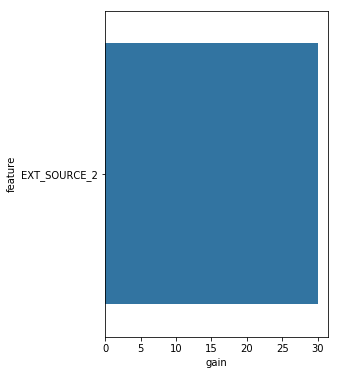

In [184]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importance = clf.feature_importance(importance_type='split')
df_importance = pd.Series(importance, name='gain').to_frame()
df_importance['gain_log'] = np.log1p(importance)
df_importance['feature'] = clf.feature_name()
# mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
# importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(4, 6))
sns.barplot(x='gain', y='feature', data=df_importance.sort_values('gain', ascending=False))